## Setup Simulation

Import needed libraries and define constants

In [1]:
%matplotlib inline
# Imports
from rcfdtd_sim import Sim, Current, Mat, vis
import numpy as np
from scipy.fftpack import fft, fftfreq, fftshift
from matplotlib import pyplot as plt
from pathlib import Path
# Determine file save name
fsave = 'sim_res_v2.npz'
# Constants
c0 = 1 # um/ps
di = 0.3 # 0.3 um
dn = di/c0 # (0.3 um) / (300 um/ps) = 0.001 ps = 1 fs
epsilon0 = 1
mu0 = 1

Define simulation bounds (total width $2$mm and total time $30$ps) and calculate length in indicies

In [2]:
# Define bounds
i0 = -500 # -500 um
i1 = 1500 # 1500 um
n0 = -900 # (1 fs) * (-900 um) / (0.3 um/step) = (1 fs) * (-3,000 steps) = -3,000 fs = -3 ps
n1 = 8100 # (1 fs) * (8100 um) / (0.3 um/step) = (1 fs) * (27,000 steps) = 27,000 fs = 27 ps
# Calculate dimensions
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)

In [3]:
print(nlen, ilen)

30000 6668


Create our time and space arrays to help construct our material and current pulse

In [4]:
# Create a arrays that hold the value of the center of each cell
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False) * (10/3) # Multiply by 10/3 to get from um -> fs
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)

## Setup Current

Specify the location of our current pulse in time and space

In [5]:
cp_loc_val = -250 # -250 um
cp_time_val = 0 # 0 fs

Determine the simulation indicies that correspond to these locations

In [6]:
# Find indicies
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
cp_time_ind = np.argmin(np.abs(np.subtract(t, cp_time_val)))
# Find start and end indicies in time
spread = int(500 / 1) # (500 fs) / (1 fs/step) = 500 steps
cp_time_s = cp_time_ind - spread
cp_time_e = cp_time_ind + spread

Create the current pulse

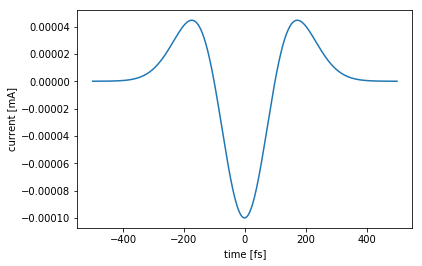

In [7]:
# Make pulse
cpulse = np.append(np.diff(np.diff(np.exp(-((t[cp_time_s:cp_time_e]-cp_time_val)**2)/(2e4)))), [0,0])
# Plot
plt.plot(t[cp_time_s:cp_time_e], cpulse)
plt.xlabel('time [fs]')
plt.ylabel('current [mA]')
plt.show()
# Create Current object
current = Current(nlen, ilen, cp_time_s, cp_loc_ind, cpulse)

## Setup Material

Specify the location of our material (which will be $1.25$mm in length)

In [8]:
# Set material length
m_len = 1250 # 1250 um = 1.25mm
# Set locations
m_s_val = 0
m_e_val = m_s_val + m_len

Calculate the starting and ending indicies of our material

In [9]:
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))

Setup material behavior

In [10]:
# Set constants
a = np.complex64(0)
gamma = np.complex64(0.01)
freq = np.complex64(0)
# Calculate beta
ang_gamma = np.complex64(gamma * 2 * np.pi)
omega = np.complex64(freq * 2 * np.pi)
beta = np.sqrt(np.add(np.square(ang_gamma), -np.square(omega)), dtype=np.complex64)
a1 = np.complex64(a/(2*beta))
a2 = np.complex64(-a/(2*beta))

In [11]:
print(gamma, beta, a1, a2)

(0.01+0j) (0.06283185+0j) 0j (-0+0j)


Create our material behavior matrices

In [12]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * ang_gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

Create our material object

In [13]:
inf_perm = 16
material = Mat(dn, ilen, nlen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta, storelocs=[1])

## Running the Simulation

Create and run our simulation (or load simulation if one already exists)

In [14]:
# Create Sim object
s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current, material, nstore=int(nlen/40), storelocs=[5,ilen-6])
# Run simulation if simulation save doesn't exist
sim_file = Path(fsave)
if sim_file.is_file():
    # Load results
    dat = np.load(fsave)
    n = dat['n']
    ls = dat['ls']
    els = dat['els']
    erls = dat['erls']
    hls = dat['hls']
    hrls = dat['hrls']
    chi = dat['chi']
else:
    # Run simulation
    s.simulate()
    # Export visualization
    vis.timeseries(s, iunit='um')#, fname=fsave+'.mp4')
    # Export and save arrays
    n, ls, els, erls, hls, hrls = s.export_locs()
    ls_mat, chi = material.export_locs()
    n = n * (10/3) # 10/3 scale factor converts from um -> fs
    np.savez(fsave, n=n, ls=ls, els=els, erls=erls, hls=hls, hrls=hrls, chi=chi)

Plot fields in time

/Users/jroth/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


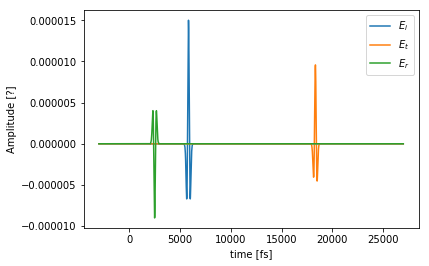

In [15]:
# Extract incident, transmitted, and reflected fields
inc = erls[:,1]
trans = els[:,1]
refl = els[:,0] - erls[:,0]

# Plot
plt.plot(n, inc, label='$E_i$')
plt.plot(n, trans, label='$E_t$')
plt.plot(n, refl, label='$E_r$')
plt.ylabel('Amplitude [?]')
plt.xlabel('time [fs]')
plt.legend()
plt.show()

Transform time-domain fields into frequency domain fields, extract transmission coefficient $\tilde T=A(\omega)+i\phi(\omega)$ into `spec_m` and `spec_a` arrays representing $A(\omega)$ and $\phi(\omega)$, respectively. To prevent a `divide by zero` error we remove the indicies at which the incident field $E_i(\omega)$ is zero.

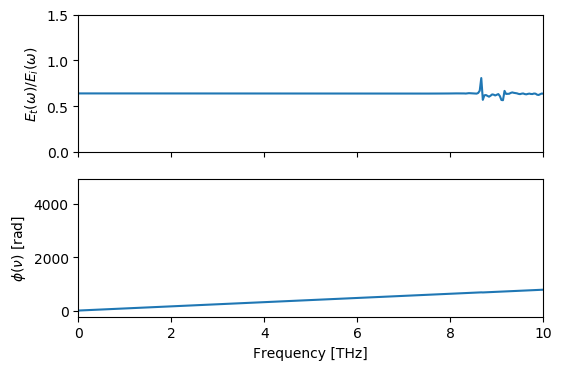

In [17]:
# Calculate time difference
dn = np.diff(n)[0] # Calculate time step difference in fs

# Calculate Fourier transforms
freq = fftfreq(nlen, dn) * 1e3 # in THz (since dn=1fs, 1/dt = 1/fs = 10^15/s = 10^3*10^12/s = 10^3*THz)
incf = fft(inc)
transf = fft(trans)

# Removeunwanted frequencies
freq = freq[1:int(nlen/2)]
incf = incf[1:int(nlen/2)]
transf = transf[1:int(nlen/2)]

# Remove zero indicies from all arrays
nonzero_ind = np.nonzero(incf)
freq = freq[nonzero_ind]
incf = incf[nonzero_ind]
transf = transf[nonzero_ind]

# Calculate spectrum in frequency
spec = np.divide(transf, incf)
spec_m = np.absolute(spec)
spec_a = np.abs(np.unwrap(np.angle(spec)))

# Plot
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, dpi=100)
ax0.plot(freq, spec_m)
ax1.plot(freq, spec_a)
ax0.set_ylim(0, 1.5)
ax1.set_xlim(0, 1e1)
ax0.set_ylabel(r'$E_t(\omega)/E_i(\omega)$')
ax1.set_ylabel(r'$\phi(\nu)$ [rad]')
ax1.set_xlabel(r'Frequency [THz]')
plt.show()

We wish to calculate the index of refraction
$$\tilde{n}(\omega)=n(\omega)+i\kappa(\omega)$$
where $\kappa\ll n$. From Benjamin Ofori-Okai's 2016 PhD thesis p. 132 we note that in this case
$$n(\omega)=\frac{c_0}{\omega d}\phi(\omega)+1$$
where $\phi$ is the phase of the complex transmission $\tilde{T}$ and $d$ is the length of the material. Ben's thesis also notes that
$$\kappa(\omega)=-\frac{c_0}{\omega d}\ln{\left(A(\omega)\frac{\left(n(\omega)+1\right)^2}{4n(\omega)}\right)}$$
where $A(\omega)$ is the magnitude of the complex transmission $\tilde{T}$. However, $\kappa\ll n$ is not a valid assumption to make in this simulation, as we are not in the _thick sample limit_. Rather we are in the _thin sample limit_, meaning a different calculation must be performed.

In [ ]:
# Set constants (MAKE SURE THAT THESE ARE UP TO DATE WITH DATA TO LOAD IN)
c0 = 1 # 300 um/ps : Taken from original.py
L = 1250/300 # 1250 um / (300 um/ps) = 125 ps / 30 : Material length (manually divided by 300 um/ps as c0 = 1)

# Calculate the angular frequency
ang_freq = 2 * np.pi * freq # THz * 2pi

# Calculate coefficients
coeff = np.divide(c0, np.multiply(ang_freq, L))

# Calculate the real part of the index of refraction
n1 = np.multiply(coeff, spec_a) + 1

# Calculate the imaginary part of the index of refraction
kappa1 = np.multiply(-coeff, np.log(np.multiply(spec_m, np.divide(np.square(n1+1), 4*n1))))

We finally plot these results

In [ ]:
# Setup plot
fig = plt.figure(dpi=100)
fig.set_dpi(150)
ax0 = plt.gca()
ax0.set_title('Simulation')
ax0.set_xlabel(r'$\omega$ [$2\pi\times$THz]')
ax0.set_ylabel(r'$n$')
ax1 = ax0.twinx()
ax1.set_ylabel(r'$\kappa$')

# Plot n
n1_line, = ax0.plot(ang_freq, n1, 'b-')
ax0.set_xlim(0, 2*np.pi*1e1)
ax0.set_ylim(4, 4.01)

# Plot kappa
kappa1_line, = ax1.plot(ang_freq, kappa1, 'r--')

# Post formatting and display
ax0.legend((n1_line, kappa1_line), ('$n$', '$\kappa$'), loc=1)
plt.tight_layout()
plt.show()

We create one large figure containing all of our plots

In [ ]:
# Setup figure
plt.close('all')
fig = plt.figure(figsize=(12, 8), dpi=600)

# Setup axes
ax_current = plt.subplot2grid((5,3), (1, 0), 2, 1)
ax_freq = plt.subplot2grid((5,3), (1, 1), 2, 2)
ax_time = plt.subplot2grid((5,3), (0, 0), 1, 3)
ax_t = plt.subplot2grid((5,3), (3, 0), 1, 2, sharex = ax_freq)
ax_p = plt.subplot2grid((5,3), (4, 0), 1, 2, sharex = ax_t)
ax_n = plt.subplot2grid((5,3), (3, 2), 2, 1)
ax_k = ax_n.twinx()

# Time axis
ax_time.plot(n*1e-3, inc, label='$E_i(t)$')
ax_time.plot(n*1e-3, trans, label='$E_t(t)$')
ax_time.plot(n*1e-3, refl, label='$E_r(t)$')
ax_time.set_ylabel('amplitude [?]')
ax_time.set_xlabel('time [ps]')
ax_time.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

# Current axis
ax_current.plot(t[cp_time_s:cp_time_e], cpulse)
ax_current.set_ylabel('current [?]')
ax_current.set_xlabel('time [fs]')
ax_current.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

# Frequency axis
ax_freq.plot(freq, np.abs(incf), label='$E_i(\omega)$')
ax_freq.plot(freq, np.abs(transf), label='$E_t(\omega)$')
ax_freq.set_ylabel('amplitude [?]')
ax_freq.set_xlabel('frequency [THz]')
ax_freq.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0)

# Coefficient plot
ax_t.plot(freq, spec_m)
ax_t.set_ylim(0,1)
ax_t.set_ylabel(r'$E_t(\omega)/E_i(\omega)$')

ax_p.plot(freq, spec_a)
ax_p.set_ylim(0,1e3)
ax_p.set_ylabel(r'$\phi(\nu)$ [rad]')
ax_p.set_xlabel(r'frequency [THz]')
ax_p.ticklabel_format(style='sci', scilimits=(0,0), axis='y')

# Index of refraction plot
n1_line, = ax_n.plot(ang_freq, n1, 'k-')
kappa1_line, = ax_k.plot(ang_freq, kappa1, 'k--')
ax_n.set_xlabel(r'$\omega$ [$2\pi\times$THz]')
ax_n.set_ylabel(r'$n$')
ax_k.set_ylabel(r'$\kappa$')
ax_n.set_xlim(0, 2*np.pi*1e1)
ax_n.set_ylim(4, 4.01)
ax_n.legend((n1_line, kappa1_line), ('$n$', '$\kappa$'), bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode='expand', borderaxespad=0)

# Final setup
ax_time.set_title(r'RC-FDTD Simulation: $\epsilon_\infty=16$, $\chi(\omega)=0$, L=$1.25$mm, THz pulse')
ax_p.set_xlim(0,10)
plt.tight_layout()

# Show figure
fig.savefig(fname='/Users/jroth/Downloads/export.pdf', format='pdf')
fig.show()